In [1]:
import gc, torch
import os
from modules import paths
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer,default_data_collator, Trainer, TrainingArguments, DataCollatorWithPadding, set_seed, TrainerCallback, AutoModelForSequenceClassification
import pandas as pd
from modules.dataset import get_page_len_dataset
from modules.transformer_model import build_model, metrics
import nest_asyncio
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
import optuna


In [ ]:
nest_asyncio.apply()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Utilizzo:", device)
set_seed(0)


Utilizzo: cuda


In [4]:

df_train = get_page_len_dataset('train')
df_val = get_page_len_dataset('valid')


labels = sorted(df_train['label'].unique())
lab2id = {l:i for i,l in enumerate(labels)}
df_train['label'] = df_train['label'].map(lab2id)
df_val  ['label'] = df_val  ['label'].map(lab2id)

train_ds = Dataset.from_pandas(df_train[['description','label']])
val_ds   = Dataset.from_pandas(df_val  [['description','label']])

In [5]:
model_type = "xlm-roberta-base"
batch_size = 16
epochs = 3
learning_rate = 1e-4
weight_decay = 0.01
classes = 3


In [6]:
model = build_model(model_type, classes).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_type)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def tokenize(examples):
    return tokenizer(examples["description"], padding="max_length", truncation=True, max_length=128)

In [8]:
train_data = train_ds.map(tokenize, batched=True, remove_columns=["description"])
val_data = val_ds.map(tokenize, batched=True, remove_columns=["description"])
train_data = train_data.rename_column("label", "labels")
val_data   = val_data.rename_column("label", "labels")


Map:   0%|          | 0/6249 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [9]:
collator = DataCollatorWithPadding(tokenizer=tokenizer)
training_args = TrainingArguments(
    output_dir=".results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    logging_dir="./logs",
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
)


In [12]:
small_train = train_data.select(range(500))
small_val= val_data.select(range(200))

def objective(trial: optuna.Trial) -> float:
    
    try:
        del model
    except NameError:
        pass
    gc.collect()
    torch.cuda.empty_cache()
    
    lr = trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True)
    bs = trial.suggest_categorical("per_device_train_batch_size", [4,8,16])
    wd = trial.suggest_float("weight_decay", 1e-8, 0.1, log=True)
    ws = trial.suggest_int("warmup_steps", 0, 500)
    ep = trial.suggest_int("num_train_epochs", 1, 3)


    hargs = TrainingArguments(
        output_dir=".tmp_hpo",
        per_device_train_batch_size=bs,
        learning_rate=lr,
        weight_decay=wd,
        warmup_steps=ws,
        num_train_epochs=ep,
        no_cuda=True,           
        logging_strategy="no",
        eval_strategy="no",
        save_strategy="no",
        disable_tqdm=False,
        report_to=None,
    )

    model = build_model(model_type, classes)

    trainer = Trainer(
        model=model,
        args=hargs,
        train_dataset=small_train,
        eval_dataset=None,
        tokenizer=tokenizer,
        data_collator=default_data_collator,
        compute_metrics=None,
    )

    trainer.train()
    pred_output = trainer.predict(small_val)
    raw_preds  = pred_output.predictions

In [ ]:
# sistema i dati

if isinstance(raw_preds, tuple):
    raw_preds = raw_preds[0]

# Se è una lista di batch, concatenali dopo averli reshapatati
if isinstance(raw_preds, (list, tuple)):
    parts = []
    for p in raw_preds:
        arr = np.asarray(p)
        if arr.ndim > 2:
            arr = arr.reshape(-1, arr.shape[-1])
        parts.append(arr)
    logits = np.concatenate(parts, axis=0)
else:
    logits = np.asarray(raw_preds)
    if logits.ndim > 2:
        logits = logits.reshape(-1, logits.shape[-1])

pred_labels = np.argmax(logits, axis=1)
true_labels = pred_output.label_ids

f1 = f1_score(true_labels, pred_labels, average="macro")

trial.report(f1, step=0)
if trial.should_prune():
    raise optuna.TrialPruned()
return float(f1)

NameError: name 'pred_output' is not defined

In [ ]:
study = optuna.create_study(
    study_name="hpo_study",
    storage="sqlite:///hpo.db",
    load_if_exists=True,
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=1)
)

study.optimize(objective, n_trials=10, n_jobs=1)
best_params = study.best_trial.params
print("Best params:", best_params)

In [ ]:
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_data.set_format(  type="torch", columns=["input_ids", "attention_mask", "labels"])

training_args = TrainingArguments(
    output_dir=".results_final",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_strategy="epoch",
    label_smoothing_factor=0.1,
    no_cuda=True,  
    **best_params
)

model = build_model(model_type, classes)
train = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    data_collator=default_data_collator,
    compute_metrics=metrics,
)

train.train()
train.save_model("final_model")
results = train.evaluate()
print("Final evaluation:", results)

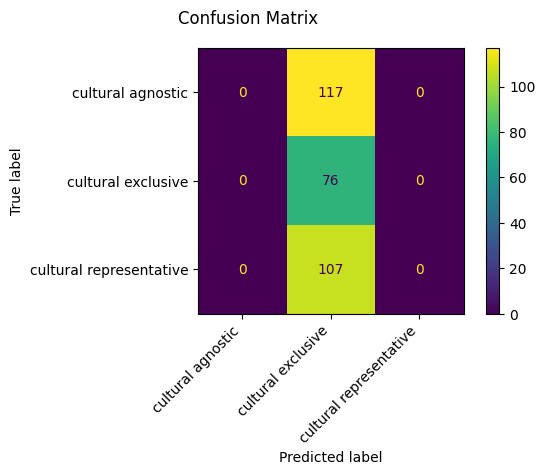

In [ ]:
pred_output = train.predict(val_data)
logits      = pred_output.predictions
true_labels = pred_output.label_ids
pred_labels = np.argmax(logits, axis=1)

disp = ConfusionMatrixDisplay.from_predictions(
    true_labels,
    pred_labels,
    display_labels=labels,    # la tua lista di nomi delle classi
    normalize=None,           # oppure "true"/"pred"/"all" per matrici normalizzate
    cmap="viridis",           # opzionale: colormap a tuo gusto
)
disp.figure_.suptitle("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()